In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import cv2
import tensorflow as tf
import skimage

from scipy.cluster.vq import *

## Data Exploration

### Insert & Preview

In [5]:
"Input gambar-gambar kita"

path = "asl_alphabet"

def load_images_from_folder(path):
  images = []
  labels = []

  for inner_folders in os.listdir(path):
      inner_path = os.path.join(path, inner_folders)

      for img_path in os.listdir(inner_path):
          full_path = os.path.join(inner_path, img_path)
          images.append(cv2.imread(full_path))
          labels.append(inner_folders)
      
  return np.array(images), np.array(labels)

images, labels = load_images_from_folder(path)

In [6]:
images.shape

(87000, 200, 200, 3)

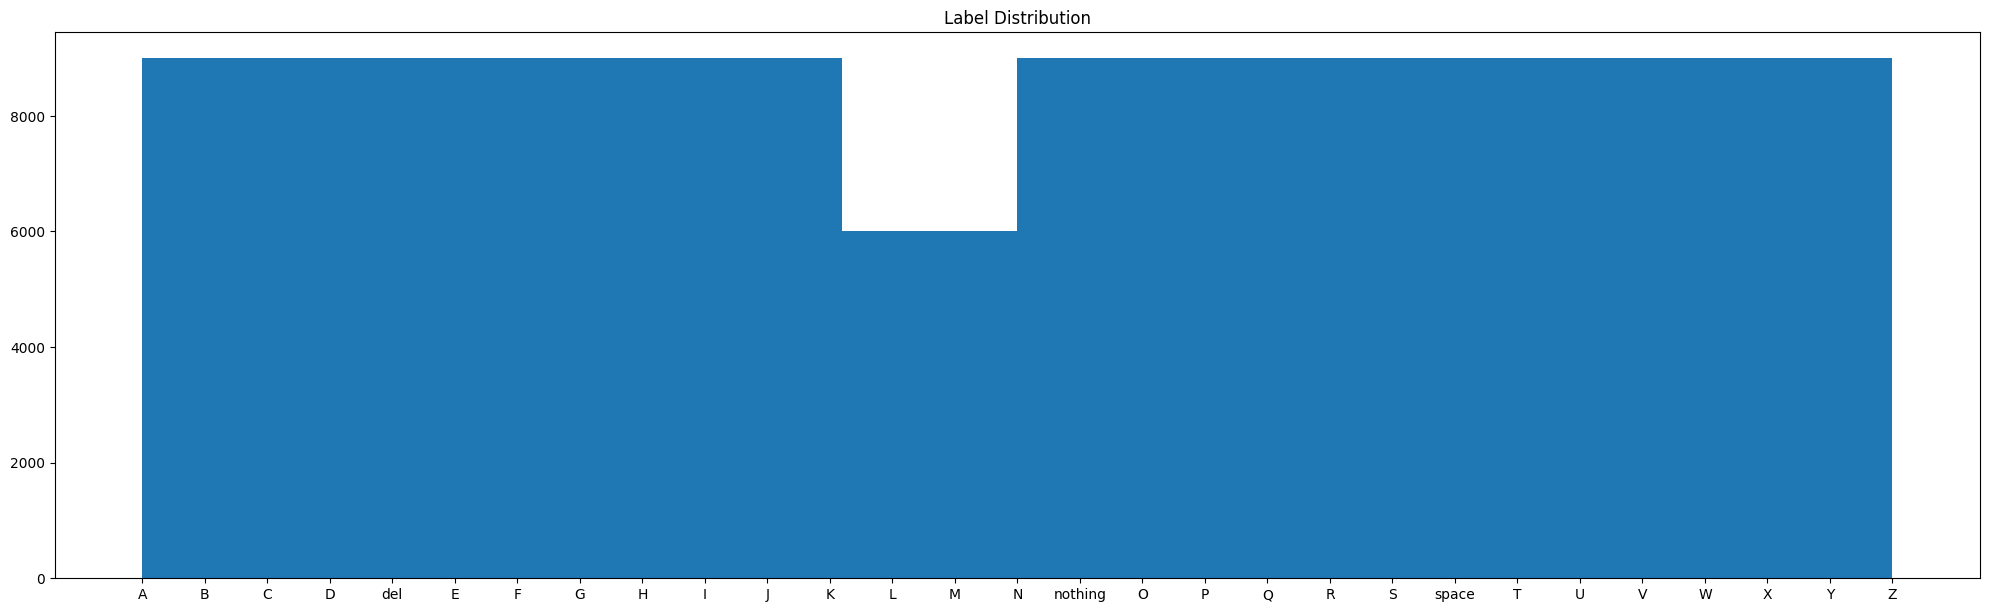

In [7]:
plt.figure(figsize=(20,6))
plt.hist(labels)
plt.tight_layout()

plt.title('Label Distribution')
plt.show()

Dataset kita ada 87.000 gambar RGB 200x200, dengan label yang kurang lebih balanced.

---

### Edge & Local Feature

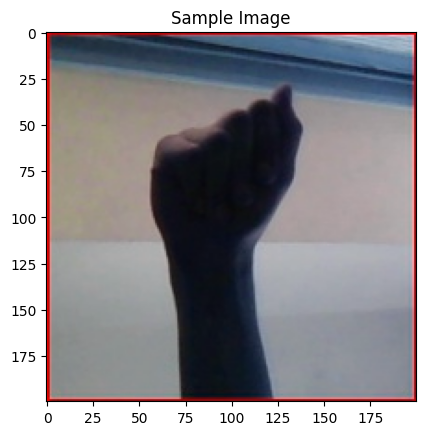

In [8]:
sample_image = images[0]

plt.imshow(sample_image, cmap='gray')
plt.title('Sample Image')
plt.show()

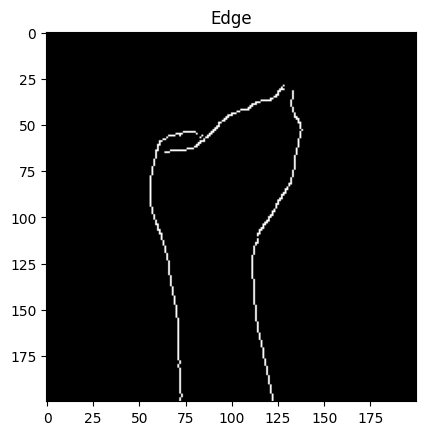

In [9]:
sample_image = images[0]

# Ubah warna jadi hitam putih
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_RGB2GRAY)

# Terapkan Gaussian Blur untuk smoothing noise sehingga edge detection menjadi lebih bagus
sample_image = cv2.GaussianBlur(sample_image, (15,15), 0)

# Deteksi Edge
sample_image = cv2.Canny(sample_image, 1, 100)

plt.imshow(sample_image, cmap='gray')
plt.title('Edge')
plt.show()

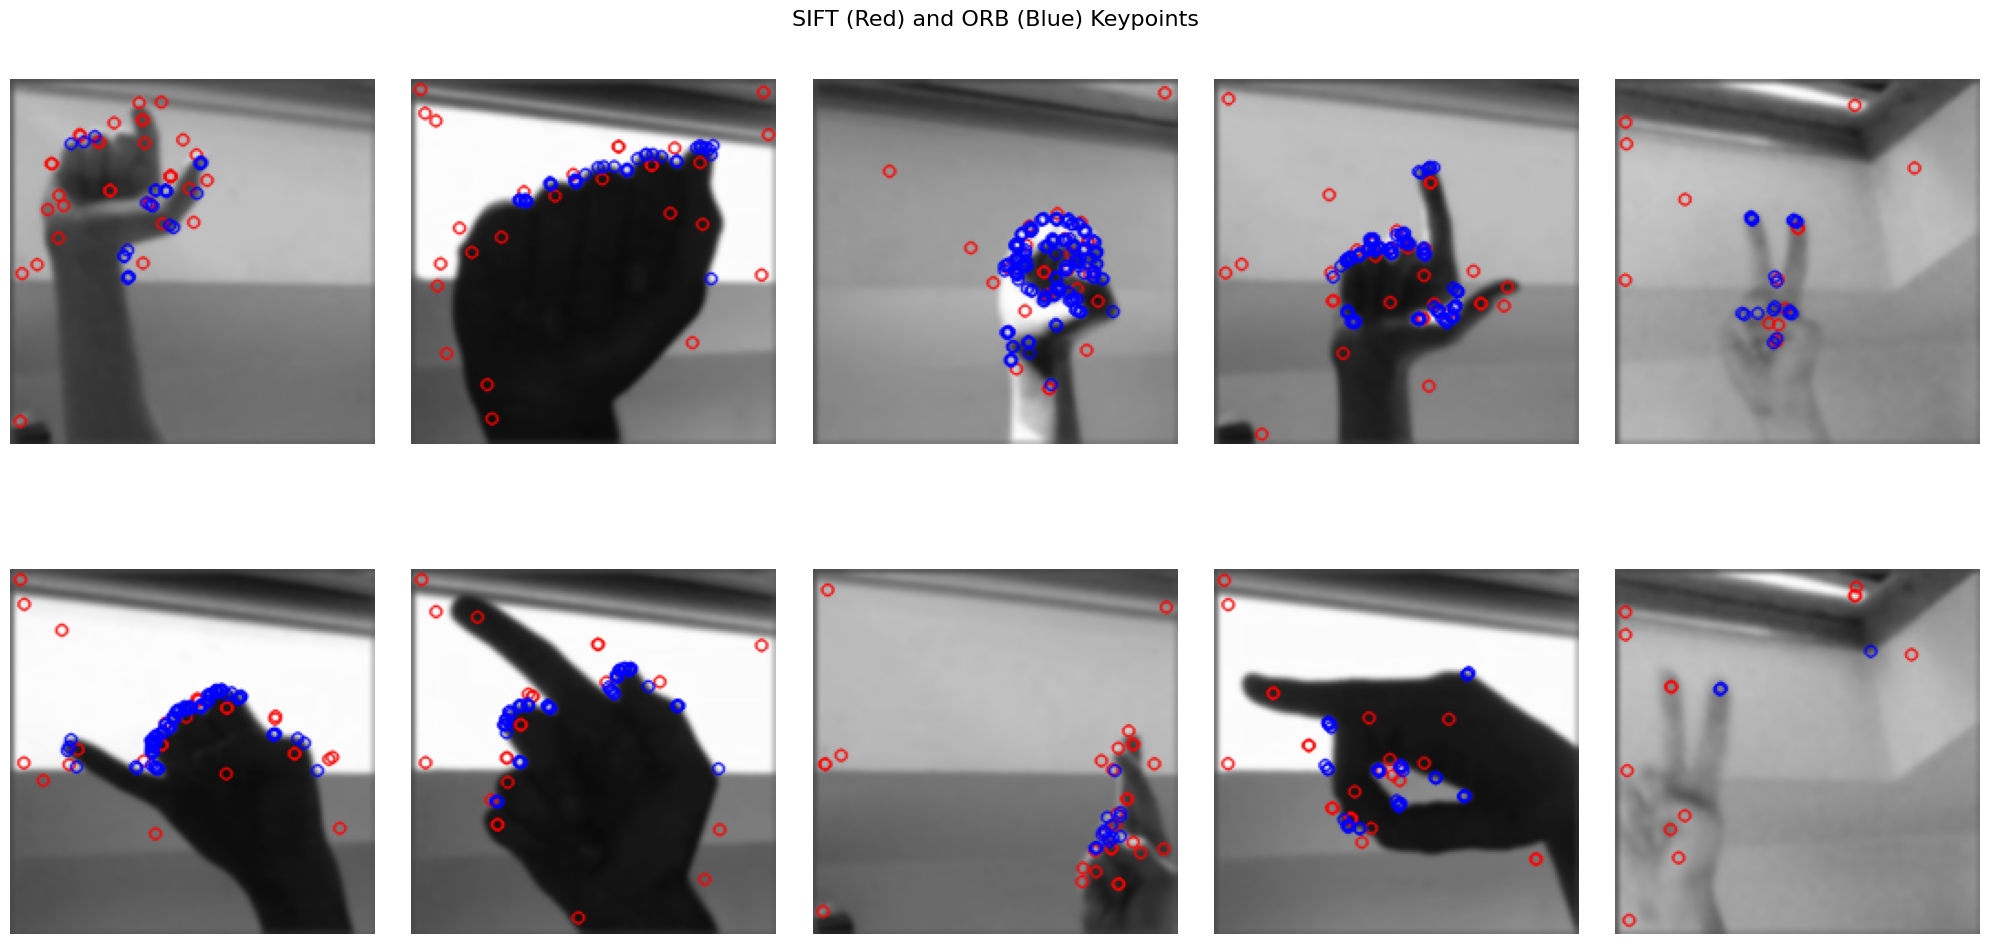

In [10]:
"Bandingkan Sift & Orb"

random_indices = np.random.randint(0, 87000, size=10)
sample_image = [images[i] for i in random_indices]

plt.figure(figsize=[20,10])

for idx, image in enumerate(sample_image):
    # Convert to grayscale and apply GaussianBlur
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.GaussianBlur(image, (7, 7), 0)

    # Initialize SIFT and ORB
    sift = cv2.SIFT_create()
    orb = cv2.ORB_create()

    # Detect keypoints and descriptors
    sift_keypoints, sift_descriptors = sift.detectAndCompute(image, None)
    orb_keypoints, orb_descriptors = orb.detectAndCompute(image, None)

    # Draw the keypoints
    sift_image = cv2.drawKeypoints(image, sift_keypoints, None, color=(255, 0, 0))  # Red for SIFT
    orb_image = cv2.drawKeypoints(sift_image, orb_keypoints, None, color=(0, 0, 255))  # Blue for ORB

    # Plot the result in a 5x2 grid
    row = idx // 2  # Determine row number (integer division)
    col = idx % 2   # Determine column number (remainder)

    plt.subplot(2, 5, idx + 1)  # 5 rows, 2 columns, idx+1 to adjust for 1-based indexing in subplot
    plt.imshow(orb_image, cmap='gray')
    plt.axis('off')  # Hide axis for better visualization

plt.suptitle('SIFT (Red) and ORB (Blue) Keypoints', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

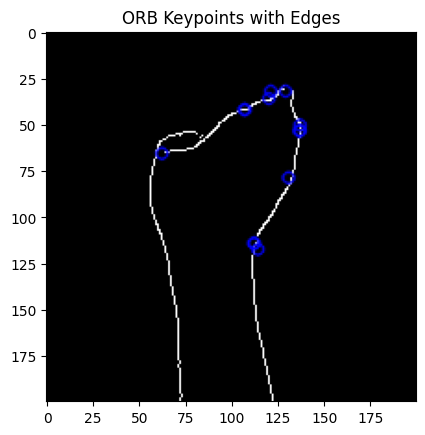

In [11]:
# Make a copy of the original image to apply transformations
sample_image = images[0]

sample_image = cv2.cvtColor(sample_image, cv2.COLOR_RGB2GRAY)

find_keypoints = cv2.GaussianBlur(sample_image, (7, 7), 0)
orb_keypoints, orb_descriptors = orb.detectAndCompute(find_keypoints, None)

find_edge = cv2.GaussianBlur(sample_image, (15, 15), 0)
sample_image = cv2.Canny(find_edge, 1, 100)

sample_image = cv2.drawKeypoints(sample_image, orb_keypoints, None, color=(0, 0, 255))

sample_image = sample_image / 255.0

plt.imshow(sample_image, cmap='gray')
plt.title('ORB Keypoints with Edges')
plt.show()

## Model #1 BoF

### Creating the vocabulary

In [12]:
"Split with stratify sampling keeping the label distribution"

from sklearn.model_selection import train_test_split

# Split train-test
images_train, images_test, label_train, label_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [13]:
orb = cv2.ORB_create()
descriptor_list = []

for image in images_train:
  image = cv2.GaussianBlur(image, (7, 7), 0)
  _, descriptor = orb.detectAndCompute(image, None)
  
  if descriptor is None:
    descriptor = np.zeros((1, orb.descriptorSize()), dtype=np.uint8)
  
  descriptor_list.append(descriptor)

In [14]:
# Preprocessing
stacked_descriptor = descriptor_list[0]
for descriptor in descriptor_list[1:]:
  stacked_descriptor = np.vstack((stacked_descriptor, descriptor))

stacked_descriptor = np.float32(stacked_descriptor)

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Clustering
kmeans = KMeans(n_clusters=1000, max_iter=20, random_state=42)
kmeans.fit(stacked_descriptor)

centroids = kmeans.cluster_centers_

image_features = np.zeros((len(images_train), len(centroids)), 'float32')

# Vector Quantization
for i in range(len(images_train)):
  words, _ = vq(descriptor_list[i], centroids)

  for w in words:
    image_features[i][w] += 1

std_scaler = StandardScaler().fit(image_features)
image_features = std_scaler.transform(image_features)

### Model Training

In [16]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
encoded_label = encoder.fit_transform(label_train.reshape(-1, 1))

In [17]:
# ANN model to process BoF

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1000,)), 
    
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(29, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Train the model
early_stopping = EarlyStopping(
    monitor='val_loss',          
    patience=5,                  
    restore_best_weights=True,   
    verbose=1                    
)

history = model.fit(image_features, encoded_label, epochs=50, batch_size=32, validation_split=0.2, shuffle=True, callbacks=[early_stopping])

Epoch 1/50


1740/1740 [==============================] - 12s 6ms/step - loss: 2.5288 - accuracy: 0.5901 - val_loss: 1.7647 - val_accuracy: 0.7484
Epoch 2/50
1740/1740 [==============================] - 10s 6ms/step - loss: 1.8369 - accuracy: 0.7125 - val_loss: 1.6158 - val_accuracy: 0.7600
Epoch 3/50
1740/1740 [==============================] - 12s 7ms/step - loss: 1.7334 - accuracy: 0.7288 - val_loss: 1.5974 - val_accuracy: 0.7705
Epoch 4/50
1740/1740 [==============================] - 12s 7ms/step - loss: 1.6890 - accuracy: 0.7441 - val_loss: 1.5610 - val_accuracy: 0.7834
Epoch 5/50
1740/1740 [==============================] - 13s 7ms/step - loss: 1.6700 - accuracy: 0.7540 - val_loss: 1.5213 - val_accuracy: 0.7940
Epoch 6/50
1740/1740 [==============================] - 12s 7ms/step - loss: 1.6521 - accuracy: 0.7642 - val_loss: 1.5338 - val_accuracy: 0.8042
Epoch 7/50
1740/1740 [==============================] - 13s 7ms/step - loss: 1.6384 - accuracy: 0.7716 - val_loss: 1.5211 - val_

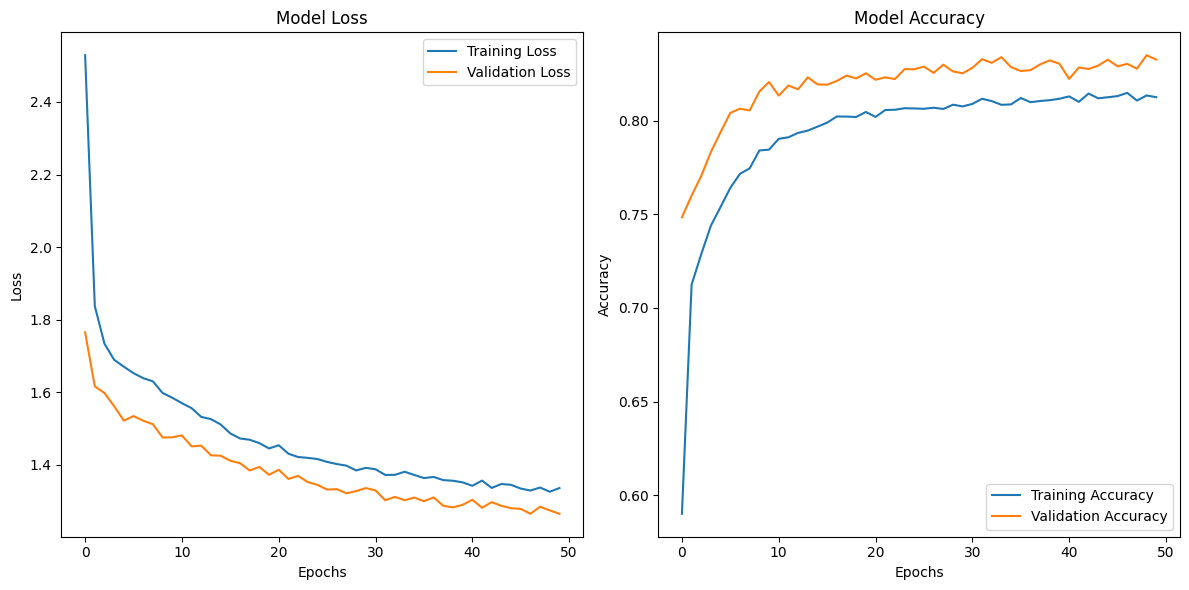

In [19]:
# Plot Training & Validation Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Testing

In [20]:
def return_histogram(img):
  _, descriptor = orb.detectAndCompute(img, None)

  if descriptor is None:
    descriptor = np.zeros((1, orb.descriptorSize()), dtype=np.uint8)

  image_features = np.zeros(len(centroids), 'float32')

  words, _ = vq(descriptor, centroids)

  for w in words:
    image_features[w] += 1

  return std_scaler.transform(image_features.reshape(1, -1))

In [21]:
def return_histogram_batch(batch_of_images):
    image_features_list = []
    
    for img in batch_of_images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        _, descriptor = orb.detectAndCompute(gray_img, None)

        if descriptor is None:
            descriptor = np.zeros((1, orb.descriptorSize()), dtype=np.uint8)

        image_features = np.zeros(len(centroids), dtype='float32')

        words, _ = vq(descriptor, centroids)

        for w in words:
            image_features[w] += 1

        image_features_list.append(image_features)

    image_features_array = np.array(image_features_list)

    return std_scaler.transform(image_features_array)


In [22]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

preprocessing_transformer = FunctionTransformer(lambda x: return_histogram_batch(x))
nn_pipeline = make_pipeline(preprocessing_transformer, model)

In [23]:
def inverse_transform_fn(predictions):
  return encoder.inverse_transform(np.argmax(predictions, axis=-1).reshape(-1, 1))

In [24]:
from sklearn.metrics import accuracy_score

pred = nn_pipeline.predict(images_test)

544/544 [==============================] - 2s 1ms/step


In [25]:
pred = inverse_transform_fn(pred)

In [26]:
accuracy_score(label_test, pred)

0.7113218390804598

In [27]:
import pickle

if kmeans:
  with open('kmeans.pkl', 'wb') as f:
      pickle.dump(kmeans, f)

if model:
  with open('Bag-of-Feature_NN_Model.pkl', 'wb') as f:
      pickle.dump(model, f)

if encoder:
  with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

if std_scaler:
  with open('scaler.pkl', 'wb') as f:
    pickle.dump(std_scaler, f)

with open('kmeans.pkl', 'rb') as f:
    kmeans = pickle.load(f)

with open('Bag-of-Feature_NN_Model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    std_scaler = pickle.load(f)

In [28]:
orb = cv2.ORB_create()
centroids = kmeans.cluster_centers_

In [29]:
def return_histogram(img):
  _, descriptor = orb.detectAndCompute(img, None)

  if descriptor is None:
    descriptor = np.zeros((1, orb.descriptorSize()), dtype=np.uint8)

  image_features = np.zeros(len(centroids), 'float32')

  words, _ = vq(descriptor, centroids)

  for w in words:
    image_features[w] += 1

  return image_features.reshape(1, -1)

### Camera Test

In [30]:
# Initialize camera
cap = cv2.VideoCapture(0)

screenshot_count = 0  # Counter for saved screenshots

while True:
    ret, frame = cap.read()  # Capture frame-by-frame
    if not ret:
        print("Failed to grab frame. Exiting...")
        break
    
    resized_frame = cv2.resize(frame, (200, 200))

    temp = cv2.GaussianBlur(frame, (7, 7), 0)
    orb_keypoints, _ = orb.detectAndCompute(temp, None)
    
    prediction = model.predict(return_histogram(resized_frame))
    predicted_class = inverse_transform_fn(prediction)

    frame = cv2.drawKeypoints(frame, orb_keypoints, None, color=(0, 0, 255))  # Blue for ORB

    # Overlay the prediction on the video feed
    cv2.putText(frame, f"Prediction: {predicted_class}", (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the frame with keypoints and prediction
    cv2.imshow("Live Feed with FAST Keypoints", frame)

    key = cv2.waitKey(1) & 0xFF

    # Exit the loop when 'q' is pressed
    if key == ord('q'):
        print("Exiting live feed...")
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 17ms/step
Exiting live feed...


## Model #2 CNN

In [34]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(200, 200, 3)),

    tf.keras.layers.Conv2D(128, (5, 5)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(29, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

# Train the model
early_stopping = EarlyStopping(
    monitor='val_loss',          
    patience=5,                  
    restore_best_weights=True,   
    verbose=1                    
)

history = model_cnn.fit(images_train, encoded_label, epochs=10, batch_size=32, validation_split=0.2, shuffle=True, callbacks=[early_stopping])

MemoryError: Unable to allocate 6.22 GiB for an array with shape (55680, 200, 200, 3) and data type uint8